In [1]:
# Import the dependencies
import numpy as np
from scipy.linalg import toeplitz, cholesky, sqrtm, inv
# import scipy.linalg as la
from scipy import signal
from scipy.integrate import odeint
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
print("Imports done")
from statistics import mean, variance, pstdev


Imports done


In [2]:
# Setting up the time data:
dt = 0.005; # integration step, average neuron resets 200 times per second
T = 100 + dt; # maximum time considered
t = np.arange(0,T,dt)
N= t.size #Amount of data points

In [3]:
#initate arrays
mu_x = np.zeros(N)
e_x = np.zeros(N)
e_y = np.zeros(N)
y =np.zeros(N)
x = np.zeros(N)
dfmu_x= np.zeros(N)

omega_w1 = np.zeros(N)
omega_w2 = np.zeros(N)
omega_z1 = np.zeros(N)
omega_z2 = np.zeros(N)

sigma_w1 = np.zeros(N)
sigma_w2= np.zeros(N)
sigma_z1 = np.zeros(N)
sigma_z2= np.zeros(N)
std = np.zeros(N)

omega_w1[0] = 1
omega_w2[0] = 1
omega_z1[0] = 1
omega_z2[0] = 1

mu_v = np.ones(N)*25
mu_x[0]= 30
x[0] = 25
u = 30

#noise standard deviations and gain
std_noise_x = 1
std_noise_y = 0.5
alpha = 0.05
alpha_mux = 1


In [4]:
#create D matrix
def derivativeD(p):
    
    D = toeplitz(np.zeros([1,p+1]),np.append(np.array([0,1]),np.zeros([1,p-1])))
           
    return D


D = derivativeD(1)

In [5]:
#GM and GP

#Generative process functions
def f_gp(x, u):
    a = -1
    # a = 0 
    b = 1
  
    return a*x + b*u

def df_gp(x, u):
    a = -1
    #a = 0
    return a



def g_gp(x):

    t0=25
    return t0 -16 / (1 + np.exp(5-x/5))

def dg_gp(x):
    
    return -16/5* np.exp(5-x/5) / (np.exp(5-x/5)+1)**2



#generative model functions
def f_gm(mu_x, mu_v):
    
    a = -1 
    b = 1
    return a*mu_x +b*mu_v


def df_gm(mu_x, mu_v):
    
    a = -1
    return a


def g_gm(mu_x,mu_v):

    t0=25
    return t0 -16 / (1 + np.exp(5-mu_x/5))

def dg_gm(mu_x,mu_v):
    
    return -16/5* np.exp(5-mu_x/5) / (np.exp(5-mu_x/5)+1)**2


In [6]:
#initiate mu_x_tilde, Atilde and I

y_tilde = np.zeros((N,2,1))
mu_x_tilde = np.zeros((N,2,1))

#mu_x_tilde[0] = [[mu_x[0]],[0]] #depending on what model you want to start with
mu_x_tilde[0] = [[mu_x[0]],[f_gm(mu_x[0], mu_v[0])]]



Atilde = np.identity(2)*(-1)
I = np.identity(2)


In [ ]:
for i in np.arange(0,N-1):

    #generative process
    x_dot = f_gp(x[i],u)
    x[i+1] = x[i] + dt*x_dot
    y_tilde[i] = [[g_gp(x[i])],[dg_gp(x[i])*f_gp(x[i],u)]]


    # Generative model
    PI_w = np.diag([omega_w1[i],omega_w2[i]])
    PI_z = np.diag([omega_z1[i],omega_z2[i]])
                             
    mu_x_hat = np.array([[1],[0]]) * f_gm(mu_x[i],mu_v[i]) +  np.array([[0],[1]])*df_gm(mu_x[i],mu_v[i])*(mu_x_tilde[i])
    mu_y_hat = np.array([[1],[0]]) * g_gm(mu_x[i],mu_v[i]) +  np.array([[0],[1]])*dg_gm(mu_x[i],mu_v[i])*(mu_x_tilde[i])
    
    print(mu_x_hat)
    eps_x = D.dot(mu_x_tilde[i])-mu_x_hat#+ np.random.randn(1)*std_noise_x
    eps_y = y_tilde[i] - mu_y_hat #+ np.random.randn(1)*std_noise_y

    #  optimization hidden state
    dFdmu_x = (D-Atilde).T.dot(PI_w).dot(eps_x) - (dg_gm(mu_x[i],mu_v[i]) * I ).T.dot(PI_z).dot(eps_y)
    dmu_x = np.dot(D,mu_x_tilde[i]) - alpha_mux*dFdmu_x #evt alpha toevoegen
    mu_x_tilde[i+1] = mu_x_tilde[i]+ dt*dmu_x
    mu_x[i+1] = mu_x_tilde[i+1,0] #use this for plotting

    dfmu_x[i+1] = mu_x_tilde[i+1,1]

    
   
    #precision optimization
    dPI_w = alpha*0.5*(inv(PI_w) - np.diag(eps_x.flatten())**2)
    dPI_z = alpha*0.5*(inv(PI_z) - np.diag(eps_y.flatten())**2)
    PI_w = PI_w + dt*dPI_w
    PI_z = PI_z + dt*dPI_z

    omega_w1[i+1] = PI_w[0,0]
    omega_w2[i+1] = PI_w[1,1]
    omega_z1[i+1] = PI_z[0,0]
    omega_z2[i+1] = PI_z[1,1]
    
    sigma_w1[i+1] = 1/omega_w1[i+1]
    sigma_w2[i+1] = 1/omega_w2[i+1]
    sigma_z1[i+1] = 1/omega_z1[i+1] 
    sigma_z2[i+1] = 1/omega_z2[i+1]


In [12]:
print(y_tilde)

[[[ 1.70000000e+01]
  [-4.00000000e+00]]

 [[ 1.69800000e+01]
  [-3.97997513e+00]]

 [[ 1.69601003e+01]
  [-3.96000149e+00]]

 ...

 [[ 1.33030627e+01]
  [-2.23521889e-13]]

 [[ 1.33030627e+01]
  [-2.23521889e-13]]

 [[ 0.00000000e+00]
  [ 0.00000000e+00]]]


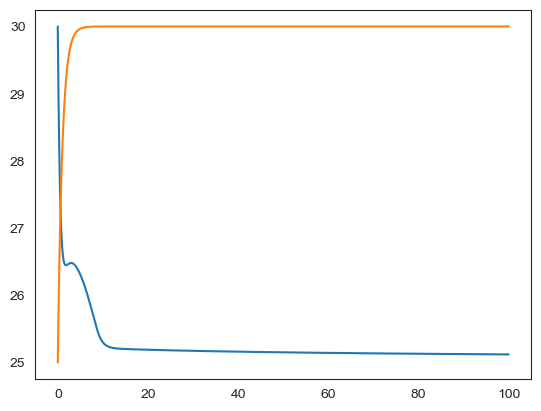

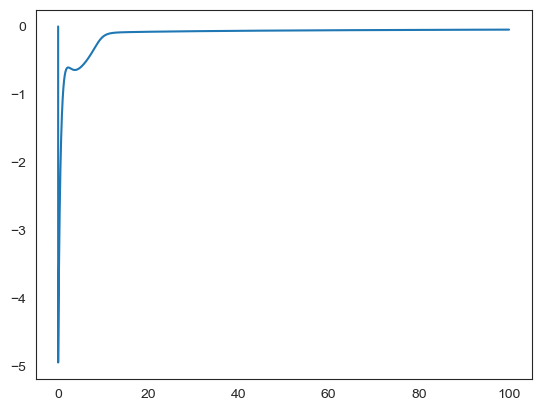

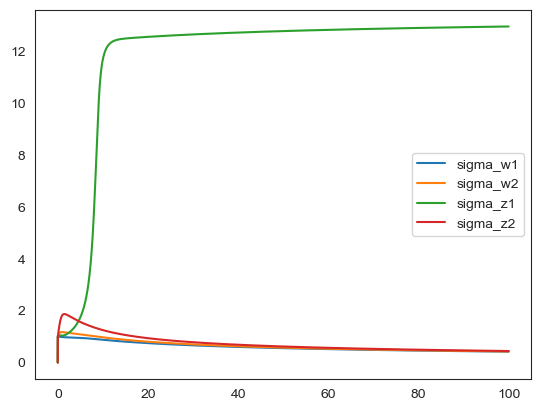

In [10]:
plt.figure()
plt.plot(t,mu_x)
plt.plot(t,x)

plt.figure()
plt.plot(t,dfmu_x)

plt.figure()
plt.plot(t,sigma_w1, label = "sigma_w1")
plt.plot(t,sigma_w2, label = "sigma_w2")
plt.plot(t,sigma_z1, label = "sigma_z1")
plt.plot(t,sigma_z2, label = "sigma_z2")
plt.legend()

